In [416]:
# Import required libraries
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import classification_report, confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt

from statsmodels.stats.outliers_influence import variance_inflation_factor
from statsmodels.tools.tools import add_constant

from scipy.stats import chi2_contingency
from scipy import stats

from sklearn.ensemble import BaggingClassifier
from sklearn.model_selection import cross_val_score

from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA

from xgboost import XGBClassifier
from lightgbm import LGBMClassifier
from catboost import CatBoostClassifier
from sklearn.ensemble import VotingClassifier, StackingClassifier
from sklearn.linear_model import LogisticRegression

In [417]:
# Load the datasets
print("Loading datasets...")
train_df = pd.read_csv('train.csv')
test_df = pd.read_csv('test.csv')

print("\nDataset shapes:")
print(f"Training data: {train_df.shape}")
print(f"Test data: {test_df.shape}")

# Display info about the training data
print("\nTraining data information:")
print(train_df.info())

Loading datasets...

Dataset shapes:
Training data: (640, 112)
Test data: (640, 112)

Training data information:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 640 entries, 0 to 639
Columns: 112 entries, Source_IP to label
dtypes: float64(16), int64(92), object(4)
memory usage: 560.1+ KB
None


In [418]:
# Separate features and target
target_column = train_df.columns[-1]  # Assuming 'label' is the last column
X = train_df.drop(columns=[target_column])  # X = all columns except the last. This is our features
y = train_df[target_column]  # y = last column. This is our target.

print("\nFeature and target shapes:")
print(f"Features (X): {X.shape}")
print(f"Target (y): {y.shape}")


Feature and target shapes:
Features (X): (640, 111)
Target (y): (640,)


In [419]:
# Handle categorical columns
print("\nHandling categorical columns...")
categorical_columns = X.select_dtypes(include=['object']).columns  # Select object type columns
print(f"Found {len(categorical_columns)} categorical columns: {list(categorical_columns)}")

# Initialize label encoders dictionary
label_encoders = {}

# Encode categorical columns
for col in categorical_columns:
    print(f"\nEncoding column: {col}")
    print(f"Original unique values: {X[col].nunique()}")
    
    le = LabelEncoder()
    # Combine train and test data for encoding
    combined_data = pd.concat([X[col], test_df[col]])
    le.fit(combined_data.astype(str))
    
    # Transform both training and test data
    X[col] = le.transform(X[col].astype(str))
    test_df[col] = le.transform(test_df[col].astype(str))
    
    label_encoders[col] = le
    print(f"Encoded unique values: {len(le.classes_)}")



Handling categorical columns...
Found 3 categorical columns: ['Source_IP', 'Destination_IP', 'Protocol']

Encoding column: Source_IP
Original unique values: 8
Encoded unique values: 9

Encoding column: Destination_IP
Original unique values: 330
Encoded unique values: 468

Encoding column: Protocol
Original unique values: 2
Encoded unique values: 2


In [420]:
# First, let's see what columns we have in both datasets
print("Training data columns:", X.columns.tolist())
print("\nTest data columns:", test_df.columns.tolist())

# Check data types for both datasets
print("\nTraining data types:")
print(X.dtypes)
print("\nTest data types:")
print(test_df.dtypes)

# Function to find problematic values in a DataFrame
def find_problematic_values(df):
    for column in df.columns:
        try:
            df[column].astype(float)
        except ValueError:
            print(f"\nProblematic column: {column}")
            print("Sample unique values:", df[column].unique()[:5])
            print("Number of unique values:", df[column].nunique())

print("\nChecking problematic values in training data:")
find_problematic_values(X)

print("\nChecking problematic values in test data:")
find_problematic_values(test_df)

# Let's handle the encoding more carefully
categorical_columns = []
for column in X.columns:
    # Check if column contains any non-numeric values
    if not pd.to_numeric(X[column], errors='coerce').notnull().all() or \
       not pd.to_numeric(test_df[column], errors='coerce').notnull().all():
        categorical_columns.append(column)

print("\nIdentified categorical columns:", categorical_columns)

# Encode categorical columns
label_encoders = {}
for col in categorical_columns:
    print(f"\nProcessing column: {col}")
    le = LabelEncoder()
    # Combine unique values from both train and test
    combined_values = pd.concat([X[col], test_df[col]]).unique()
    le.fit(combined_values.astype(str))
    
    # Transform the data
    X[col] = le.transform(X[col].astype(str))
    test_df[col] = le.transform(test_df[col].astype(str))
    
    label_encoders[col] = le
    print(f"Encoded {col}: {len(le.classes_)} unique values")

# Now try converting to float again
try:
    X = X.astype(float)
    print("\nSuccessfully converted training data to float")
except ValueError as e:
    print("\nError in converting training data:", e)
    
try:
    test_df = test_df.astype(float)
    print("Successfully converted test data to float")
except ValueError as e:
    print("\nError in converting test data:", e)

# Verify final data types
print("\nFinal data types - Training:")
print(X.dtypes.value_counts())
print("\nFinal data types - Test:")
print(test_df.dtypes.value_counts())

# Additional verification step
print("\nVerifying no remaining string values:")
for column in X.columns:
    try:
        X[column].astype(float)
        test_df[column].astype(float)
    except ValueError:
        print(f"Column {column} still contains non-numeric values")

Training data columns: ['Source_IP', 'Source_port', 'Destination_IP', 'Destination_port', 'Protocol', 'Timestamp', 'fwd_packets_amount', 'bwd_packets_amount', 'fwd_packets_length', 'bwd_packets_length', 'max_fwd_packet ', 'min_fwd_packet', 'max_bwd_packet', 'min_bwd_packet', 'FIN_count', 'SYN_count', 'RST_count', 'PSH_count', 'silence_windows', 'min_fwd_inter_arrival_time', 'max_fwd_inter_arrival_time', 'mean_fwd_inter_arrival_time', 'min_bwd_inter_arrival_time', 'max_bwd_inter_arrival_time', 'mean_bwd_inter_arrival_time', 'min_bib_inter_arrival_time', 'max_bib_inter_arrival_time', 'mean_bib_inter_arrival_time', 'first_packet_sizes_0', 'first_packet_sizes_1', 'first_packet_sizes_2', 'first_packet_sizes_3', 'first_packet_sizes_4', 'first_packet_sizes_5', 'first_packet_sizes_6', 'first_packet_sizes_7', 'first_packet_sizes_8', 'first_packet_sizes_9', 'first_packet_sizes_10', 'first_packet_sizes_11', 'first_packet_sizes_12', 'first_packet_sizes_13', 'first_packet_sizes_14', 'first_packet_s

In [421]:
first_selection_threshold = 0.97
second_selection_lower_threshold = 0.85
second_selection_upper_threshold = 0.98
## First selection: Features with same value in 97% or more of the data
def find_constant_features(df, threshold=0.97):
    constant_features = []
    for column in df.columns:
        # Calculate the proportion of the most frequent value
        most_frequent_prop = df[column].value_counts(normalize=True).iloc[0]
        if most_frequent_prop >= threshold:
            constant_features.append(column)
    
    return constant_features

# Second selection: Check distribution of features with same value in 85-97% of data
def analyze_near_constant_features(df, y, lower_threshold=0.85, upper_threshold=0.98):
    features_to_remove = []
    total_classes = len(np.unique(y))
    
    print(f"Total number of classes in dataset: {total_classes}")
    
    # Expected uniform distribution probability
    uniform_prob = 1.0 / total_classes
    # Allow some deviation from uniform (e.g., 2x the uniform probability)
    max_allowed_prob = uniform_prob * 2
    
    for column in df.columns:
        # Get value counts and proportions
        value_counts = df[column].value_counts(normalize=True)
        most_frequent_prop = value_counts.iloc[0]
        most_frequent_value = value_counts.index[0]
        
        # If feature has same value in 85-97% of data
        if lower_threshold <= most_frequent_prop < upper_threshold:
            # Get the minority cases (where value is different from most frequent)
            minority_mask = df[column] != most_frequent_value
            minority_labels = y[minority_mask]
            
            # Check distribution of classes in minority cases
            class_distribution = minority_labels.value_counts(normalize=True)
            
            print(f"\nAnalyzing feature: {column}")
            print(f"Most frequent value appears in {most_frequent_prop:.2%} of data")
            print("Class distribution in minority cases:")
            print(class_distribution)
            
            # Analyze distribution
            if len(class_distribution) > 1:  # Only if there are multiple classes
                max_class_prop = class_distribution.max()
                
                # Calculate entropy of distribution
                entropy = -sum(p * np.log2(p) for p in class_distribution)
                max_entropy = -np.log2(1/total_classes)  # Maximum possible entropy
                entropy_ratio = entropy / max_entropy
                
                print(f"Entropy ratio: {entropy_ratio:.2f} (1.0 would be perfectly uniform)")
                
                # Decision criteria:
                # 1. If any class is heavily overrepresented
                # 2. Or if distribution is close to uniform
                if max_class_prop < max_allowed_prob or entropy_ratio > 0.8:
                    features_to_remove.append(column)
                    print("REMOVED: Distribution is too uniform or lacks clear class separation")
                else:
                    print("KEPT: Shows significant class separation")
            else:
                print("KEPT: Only one class in minority cases (strong predictor)")
                
    return features_to_remove

# Apply the feature selection
print("Starting feature selection...")
print(f"Number of unique classes in dataset: {len(np.unique(y))}")

# First stage: Remove highly constant features
constant_features = find_constant_features(X, first_selection_threshold)
print(f"\nFound {len(constant_features)} features with {first_selection_threshold}% constant values:")
for feat in constant_features:
    value_counts = X[feat].value_counts(normalize=True)
    print(f"{feat}: Most common value appears in {value_counts.iloc[0]:.2%} of cases")

# Remove these features
X = X.drop(columns=constant_features)
test_df = test_df.drop(columns=constant_features)

# Second stage: Analyze near-constant features
features_to_remove = analyze_near_constant_features(X, y, second_selection_lower_threshold, second_selection_upper_threshold)
print(f"\nFound {len(features_to_remove)} near-constant features to remove:")
for feat in features_to_remove:
    print(f"\n{feat}:")
    value_counts = X[feat].value_counts(normalize=True)
    print(f"Value distribution: {value_counts.head()}")

# Remove these features
X = X.drop(columns=features_to_remove)
test_df = test_df.drop(columns=features_to_remove)

print("\nFeature selection completed.")
print(f"Number of features after selection: {X.shape[1]}")
print("\nRemoved features summary:")
print(f"- {len(constant_features)} highly constant features {first_selection_threshold}")
print(f"- {len(features_to_remove)} near-constant features with uniform class distribution")

Starting feature selection...
Number of unique classes in dataset: 128

Found 30 features with 0.97% constant values:
Destination_port: Most common value appears in 98.91% of cases
bandwidth_0: Most common value appears in 98.28% of cases
bandwidth_4: Most common value appears in 97.34% of cases
bandwidth_6: Most common value appears in 99.06% of cases
bandwidth_8: Most common value appears in 99.84% of cases
bandwidth_10: Most common value appears in 99.69% of cases
bandwidth_12: Most common value appears in 100.00% of cases
bandwidth_14: Most common value appears in 99.84% of cases
bandwidth_16: Most common value appears in 100.00% of cases
bandwidth_18: Most common value appears in 100.00% of cases
bandwidth_19: Most common value appears in 97.03% of cases
beaconning_1: Most common value appears in 97.97% of cases
beaconning_2: Most common value appears in 99.06% of cases
beaconning_3: Most common value appears in 99.53% of cases
beaconning_4: Most common value appears in 99.69% of 

In [422]:
def calculate_vif(X):
    """
    Calculate VIF for each feature
    Returns DataFrame with VIF scores
    """
    vif_data = pd.DataFrame()
    X_with_constant = add_constant(X)
    vif_data["Feature"] = X_with_constant.columns
    vif_data["VIF"] = [variance_inflation_factor(X_with_constant.values, i) 
                       for i in range(X_with_constant.shape[1])]
    
    # Remove the constant term's VIF
    return vif_data[vif_data['Feature'] != 'const'].sort_values('VIF', ascending=False)

def get_correlation_matrix(X):
    """
    Calculate correlation matrix and return it along with a visualization
    """
    correlation_matrix = X.corr()
    
    # Plot correlation heatmap
    # plt.figure(figsize=(12, 10))
    # sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', center=0)
    # plt.title('Feature Correlation Heatmap')
    # plt.tight_layout()
    # plt.show()
    
    return correlation_matrix

def identify_correlated_features(correlation_matrix, threshold=0.7):
    """
    Find highly correlated feature pairs
    """
    highly_correlated = []
    for i in range(len(correlation_matrix.columns)):
        for j in range(i+1, len(correlation_matrix.columns)):
            if abs(correlation_matrix.iloc[i, j]) > threshold:
                highly_correlated.append((
                    correlation_matrix.columns[i],
                    correlation_matrix.columns[j],
                    correlation_matrix.iloc[i, j]
                ))
    return highly_correlated

print("Starting multicollinearity analysis...")

# Initial VIF calculation
vif_data = calculate_vif(X)
# print("\nInitial VIF values:")
# print(vif_data)

# Get correlation matrix
correlation_matrix = get_correlation_matrix(X)

# Iterative feature removal process
features_to_remove = set()
vif_threshold = 5
correlation_threshold = 0.7

while True:
    # Get features with high VIF
    high_vif_features = vif_data[vif_data['VIF'] > vif_threshold]['Feature'].tolist()
    
    if not high_vif_features:
        break
        
    # print(f"\nFeatures with VIF > {vif_threshold}:")
    # print(vif_data[vif_data['VIF'] > vif_threshold])
    
    # Find highly correlated pairs among high VIF features
    high_vif_correlation = identify_correlated_features(
        correlation_matrix.loc[high_vif_features, high_vif_features],
        correlation_threshold
    )
    
    if not high_vif_correlation:
        # If no high correlations, remove the feature with highest VIF
        worst_feature = vif_data.iloc[0]['Feature']
        features_to_remove.add(worst_feature)
        # print(f"\nRemoving feature with highest VIF: {worst_feature} (VIF: {vif_data.iloc[0]['VIF']:.2f})")
    else:
        # Among correlated pairs, find the one with highest VIF
        # print("\nHighly correlated pairs among high VIF features:")
        for f1, f2, corr in high_vif_correlation:
            print(f"{f1} - {f2}: correlation = {corr:.2f}")
            
        vif_dict = dict(zip(vif_data['Feature'], vif_data['VIF']))
        worst_feature = max(
            high_vif_features,
            key=lambda x: vif_dict.get(x, 0)
        )
        features_to_remove.add(worst_feature)
        # print(f"\nRemoving feature: {worst_feature} (VIF: {vif_dict[worst_feature]:.2f})")
    
    # Remove selected feature and recalculate VIF
    X = X.drop(columns=[worst_feature])
    test_df = test_df.drop(columns=[worst_feature])
    vif_data = calculate_vif(X)
    correlation_matrix = X.corr()

print("\nMulticollinearity analysis completed.")
print(f"Removed {len(features_to_remove)} features due to high multicollinearity:")
# print(list(features_to_remove))

print("\nFinal feature set shape:", X.shape)
print("\nFinal VIF values:")
# print(calculate_vif(X))

Starting multicollinearity analysis...
ACK_count - bwd_packets_length: correlation = 0.99
ACK_count - fwd_packets_length: correlation = 0.93
ACK_count - bwd_packets_amount: correlation = 0.97
ACK_count - fwd_packets_amount: correlation = 0.90
ACK_count - bpp_1: correlation = 0.85
ACK_count - bandwidth_15: correlation = 0.73
ACK_count - bpp_2: correlation = 0.88
ACK_count - bpp_0: correlation = 0.80
ACK_count - silence_windows: correlation = 0.75
bwd_packets_length - fwd_packets_length: correlation = 0.86
bwd_packets_length - bwd_packets_amount: correlation = 0.98
bwd_packets_length - fwd_packets_amount: correlation = 0.83
bwd_packets_length - bpp_1: correlation = 0.85
bwd_packets_length - bandwidth_15: correlation = 0.76
bwd_packets_length - bpp_2: correlation = 0.88
bwd_packets_length - bandwidth_17: correlation = 0.72
bwd_packets_length - bpp_0: correlation = 0.81
bwd_packets_length - silence_windows: correlation = 0.79
bandwidth_9 - bandwidth_11: correlation = 1.00
bandwidth_9 - ban

In [423]:
def perform_chi_square_test(X, y, significance_level=0.05):
    """
    Perform chi-square test on categorical features
    """
    # Find categorical columns (those that were label encoded)
    results = []
    
    print("Performing Chi-square test on categorical features...")
    for column in X.columns:
        # Create contingency table
        contingency_table = pd.crosstab(X[column], y)
        
        # Perform chi-square test
        chi2, p_value, dof, expected = chi2_contingency(contingency_table)
        
        # Store results
        results.append({
            'Feature': column,
            'Chi-Square': chi2,
            'P-value': p_value,
            'Degrees of Freedom': dof
        })
    
    # Convert to DataFrame and sort by chi-square value
    results_df = pd.DataFrame(results)
    results_df = results_df.sort_values('Chi-Square', ascending=False)
    
    # Identify significant features
    significant_features = results_df[results_df['P-value'] < significance_level]
    
    # Print results
    print("\nChi-square test results:")
    print(results_df)
    print(f"\nFound {len(significant_features)} significant features at {significance_level} significance level")
    print("\nSignificant features:")
    print(significant_features['Feature'].tolist())
    
    return results_df

# Perform chi-square test
chi_square_results = perform_chi_square_test(X, y)

Performing Chi-square test on categorical features...

Chi-square test results:
                        Feature    Chi-Square        P-value  \
3                     Timestamp  81280.000000   3.757255e-01   
57                      pps_fwd  81152.000000   3.765733e-01   
58                      pps_bwd  80725.333333   3.022705e-01   
1                   Source_port  79616.000000   5.909008e-02   
49             mean_packet_size  79452.444444   1.737608e-02   
50              mean_delta_byte  77405.866667   3.381123e-04   
13   max_fwd_inter_arrival_time  74597.433962   2.287449e-82   
14  mean_fwd_inter_arrival_time  74469.433962   3.813524e-02   
2                Destination_IP  73457.980952   0.000000e+00   
17  mean_bwd_inter_arrival_time  58890.124294   4.050805e-02   
16   max_bwd_inter_arrival_time  58890.124294   3.674996e-95   
21         first_packet_sizes_4  29613.928116  1.034429e-114   
29        first_packet_sizes_12  26614.846904   7.684344e-91   
4            fwd_packets

In [424]:
def perform_anova_feature_selection(X, y, significance_level=0.05):
    """
    Perform ANOVA F-test for numeric features
    """
    results = []
    print("Performing ANOVA F-test on numeric features...")
    
    for column in X.columns:
        # Create lists of values for each class
        class_values = [X[column][y == class_label] for class_label in np.unique(y)]
        
        # Perform one-way ANOVA
        f_statistic, p_value = stats.f_oneway(*class_values)
        
        # Calculate effect size (eta-squared)
        # Between-group sum of squares
        grand_mean = np.mean([values.mean() for values in class_values])
        ss_between = sum(len(values) * (values.mean() - grand_mean)**2 for values in class_values)
        
        # Total sum of squares
        all_values = np.concatenate(class_values)
        ss_total = sum((all_values - grand_mean)**2)
        
        # Calculate eta-squared
        eta_squared = ss_between / ss_total if ss_total != 0 else 0
        
        results.append({
            'Feature': column,
            'F-statistic': f_statistic,
            'P-value': p_value,
            'Effect Size (eta²)': eta_squared
        })
    
    # Convert to DataFrame and sort by F-statistic
    results_df = pd.DataFrame(results)
    results_df = results_df.sort_values('F-statistic', ascending=False)
    
    # Identify significant features with meaningful effect size
    # Using both statistical significance and effect size thresholds
    significant_features = results_df[
        (results_df['P-value'] < significance_level) & 
        (results_df['Effect Size (eta²)'] > 0.01)  # Small effect size threshold
    ]
    
    print("\nANOVA F-test results:")
    print(results_df)
    print(f"\nFound {len(significant_features)} significant features with meaningful effect size")
    print("\nSignificant features with meaningful effect size:")
    print(significant_features['Feature'].tolist())
    
    # Create lists of features to keep and remove
    features_to_keep = significant_features['Feature'].tolist()
    features_to_remove = [col for col in X.columns if col not in features_to_keep]
    
    # Remove non-significant features or those with negligible effect size
    X_selected = X[features_to_keep]
    test_df_selected = test_df[features_to_keep]
    
    print(f"\nRemoved {len(features_to_remove)} features")
    print(f"Remaining features: {X_selected.shape[1]}")
    
    return X_selected, test_df_selected, results_df

# Perform ANOVA feature selection
X_selected, test_df_selected, anova_results = perform_anova_feature_selection(X, y)

Performing ANOVA F-test on numeric features...

ANOVA F-test results:
                        Feature  F-statistic        P-value  \
3                     Timestamp    34.682108  5.916456e-188   
0                     Source_IP    25.539881  5.409471e-159   
11                    PSH_count    10.322509   1.401123e-83   
5               max_fwd_packet     10.319443   1.472234e-83   
2                Destination_IP     6.922803   5.171337e-57   
22         first_packet_sizes_5     4.308272   4.030747e-32   
21         first_packet_sizes_4     4.269629   1.010152e-31   
51                  bandwidth_1     4.038090   2.578503e-29   
4            fwd_packets_length     3.951489   2.081657e-28   
19         first_packet_sizes_0     3.574341   2.018565e-24   
1                   Source_port     3.406590   1.239391e-22   
8                     FIN_count     3.337232   6.828384e-22   
20         first_packet_sizes_2     3.249312   5.953376e-21   
23         first_packet_sizes_6     3.106109   2

In [425]:
# # Store test labels before dropping them
# test_labels = test_df['label']

# # Remove 'label' column from test data
# if 'label' in test_df.columns:
#     test_df = test_df.drop(columns=['label'])

# # Verify column alignment
# missing_cols = set(X.columns) - set(test_df.columns)
# extra_cols = set(test_df.columns) - set(X.columns)

# if missing_cols:
#     print(f"\nWarning: Test data is missing columns: {missing_cols}")
# if extra_cols:
#     print(f"\nWarning: Test data has extra columns: {extra_cols}")

# # Ensure columns are in the same order as training data
# test_df = test_df[X.columns]

# ----------------------------------------- First version -----------------------------------------
# In this version, we will use PCA to reduce the number of features while retaining 95% of variance

# # First, scale the features
# print("\nScaling features...")
# scaler = StandardScaler()
# X_scaled = scaler.fit_transform(X)
# test_df_scaled = scaler.transform(test_df)

# # Apply PCA
# print("\nApplying PCA...")
# # Initialize PCA to retain 95% of variance
# pca = PCA(n_components=0.95)  # This will automatically select number of components
# X_pca = pca.fit_transform(X_scaled)
# test_df_pca = pca.transform(test_df_scaled)

# # Print variance explained
# cumulative_variance = np.cumsum(pca.explained_variance_ratio_)
# n_components = len(cumulative_variance)
# print(f"\nNumber of components selected: {n_components}")
# print(f"Total variance explained: {cumulative_variance[-1]:.4f}")

# # Plot explained variance ratio
# plt.figure(figsize=(10, 6))
# plt.plot(range(1, len(pca.explained_variance_ratio_) + 1), 
#          cumulative_variance, 'bo-')
# plt.xlabel('Number of Components')
# plt.ylabel('Cumulative Explained Variance Ratio')
# plt.title('Explained Variance vs Number of Components')
# plt.grid(True)
# plt.show()

# # Convert to DataFrame for easier handling
# X = pd.DataFrame(X_pca, columns=[f'PC{i+1}' for i in range(X_pca.shape[1])])
# test_df = pd.DataFrame(test_df_pca, columns=[f'PC{i+1}' for i in range(test_df_pca.shape[1])])

# ----------------------------------------- Second version -----------------------------------------
# In this version, we will use PCA to reduce the number of features to 40 components

# # First, scale the features
# print("\nScaling features...")
# scaler = StandardScaler()
# X_scaled = scaler.fit_transform(X)
# test_df_scaled = scaler.transform(test_df)

# # Apply PCA with 40 components
# print("\nApplying PCA to get top 40 components...")
# pca = PCA(n_components=40)
# X_pca = pca.fit_transform(X_scaled)
# test_df_pca = pca.transform(test_df_scaled)

# # Print variance explained
# cumulative_variance = np.cumsum(pca.explained_variance_ratio_)
# print(f"\nTotal variance explained by 40 components: {cumulative_variance[-1]:.4f}")

# # Plot explained variance ratio
# plt.figure(figsize=(10, 6))
# plt.plot(range(1, len(pca.explained_variance_ratio_) + 1), 
#          cumulative_variance, 'bo-')
# plt.xlabel('Number of Components')
# plt.ylabel('Cumulative Explained Variance Ratio')
# plt.title('Explained Variance vs Number of Components')
# plt.grid(True)
# plt.show()

# # Convert to DataFrame with named components
# X = pd.DataFrame(X_pca, columns=[f'PC{i+1}' for i in range(40)])
# test_df = pd.DataFrame(test_df_pca, columns=[f'PC{i+1}' for i in range(40)])

In [426]:
# # Split training data into train and validation sets
# print("\nSplitting training data into train and validation sets...")
# X_train, X_val, y_train, y_val = train_test_split(
#     X, y, 
#     test_size=0.2, 
#     random_state=42,
#     stratify=y  # Ensure balanced split
# )

# print(f"Training set shape: {X_train.shape}")
# print(f"Validation set shape: {X_val.shape}")

In [427]:
# Initialize and train the Random Forest model
print("\nTraining Random Forest model...")
rf_model = RandomForestClassifier(
    n_estimators=100,  # Number of trees
    random_state=42,   # For reproducibility
    n_jobs=-1          # Use all available cores
)

# rf_model.fit(X_train, y_train)
rf_model.fit(X, y)


Training Random Forest model...


RandomForestClassifier(n_jobs=-1, random_state=42)

In [428]:
# # Make predictions on validation set
# print("\nMaking predictions on validation set...")
# y_val_pred = rf_model.predict(X_val)

In [429]:
# # Print validation set performance
# print("\nValidation Set Performance:")
# print("\nClassification Report:")
# print(classification_report(y_val, y_val_pred))

print("\nModel trained on full training dataset")


Model trained on full training dataset


In [430]:
# # Create confusion matrix
# print("\nGenerating confusion matrix...")
# cm = confusion_matrix(y_val, y_val_pred)
# plt.figure(figsize=(10, 8))
# sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
# plt.title('Confusion Matrix')
# plt.ylabel('True Label')
# plt.xlabel('Predicted Label')
# plt.show()


Generating feature importance plot...


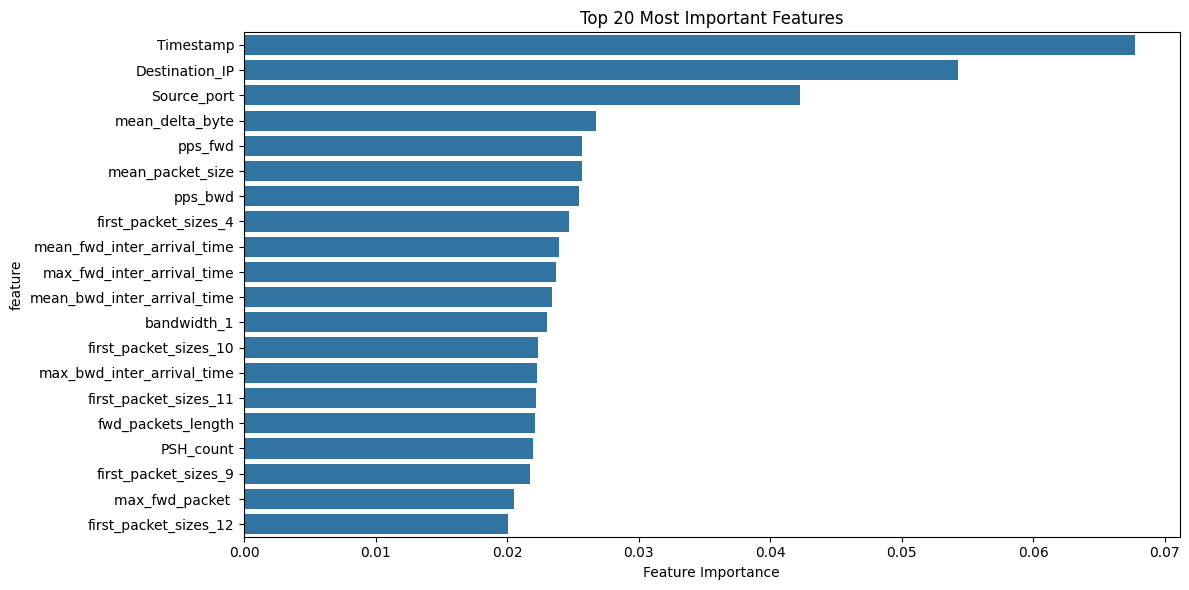

In [431]:
# Feature importance plot
print("\nGenerating feature importance plot...")
feature_importance = pd.DataFrame({
    'feature': X.columns,
    'importance': rf_model.feature_importances_
})

feature_importance = feature_importance.sort_values('importance', ascending=False)
plt.figure(figsize=(12, 6))
sns.barplot(x='importance', y='feature', data=feature_importance.head(20))
plt.title('Top 20 Most Important Features')
plt.xlabel('Feature Importance')
plt.tight_layout()
plt.show()

In [432]:
# ----------------------------------------If I choose to use PCA above, comment from here:
# Store test labels before dropping them
test_labels = test_df['label']

# Remove 'label' column from test data
if 'label' in test_df.columns:
    test_df = test_df.drop(columns=['label'])

# Verify column alignment
missing_cols = set(X.columns) - set(test_df.columns)
extra_cols = set(test_df.columns) - set(X.columns)

if missing_cols:
    print(f"\nWarning: Test data is missing columns: {missing_cols}")
if extra_cols:
    print(f"\nWarning: Test data has extra columns: {extra_cols}")

# Ensure columns are in the same order as training data
test_df = test_df[X.columns]

# ----------------------------------------To here

# Make predictions on test set
print("\nMaking predictions on test set...")
test_predictions = rf_model.predict(test_df)

# Print basic prediction statistics
print("\nPrediction counts:")
print(pd.Series(test_predictions).value_counts())

# Print full classification report
print("\nTest Set Performance:")
print("\nClassification Report:")
print(classification_report(test_labels, test_predictions))

# # Create confusion matrix
# plt.figure(figsize=(10, 8))
# cm = confusion_matrix(test_labels, test_predictions)
# sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
# plt.title('Confusion Matrix on Test Set')
# plt.ylabel('True Label')
# plt.xlabel('Predicted Label')
# plt.show()

# Calculate overall accuracy
accuracy = accuracy_score(test_labels, test_predictions)
print(f"\nOverall Accuracy on Test Set: {accuracy:.2%}")

# Save predictions with evaluation
predictions_df = pd.DataFrame({
    'True_Label': test_labels,
    'Predicted_Label': test_predictions,
    'Correct': test_labels == test_predictions
})

predictions_df.to_csv('random_forest_predictions_with_evaluation.csv', index=False)
print("\nPredictions and evaluation saved to 'random_forest_predictions_with_evaluation.csv'")



Making predictions on test set...

Prediction counts:
resources              17
ssrn                   11
flickr                 10
disneymovieinsiders    10
buzzfeed               10
                       ..
linkedin                1
ca.gov                  1
pinterest               1
vox                     1
forbes                  1
Name: count, Length: 127, dtype: int64

Test Set Performance:

Classification Report:
                       precision    recall  f1-score   support

             1inch.io       0.67      0.40      0.50         5
   20thcenturystudios       0.67      0.40      0.50         5
              YouTube       0.50      0.40      0.44         5
        aboutads.info       0.75      0.60      0.67         5
   adventuresbydisney       0.57      0.80      0.67         5
alainelkanninterviews       0.71      1.00      0.83         5
           algemeiner       0.67      0.80      0.73         5
            amazonaws       0.62      1.00      0.77         5
     

c:\Users\User\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Users\User\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Users\User\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modif

In [433]:
# Get top important features
number_of_top_features = 3
top_features = feature_importance.head(number_of_top_features)['feature'].tolist()
print(f"Selected top {number_of_top_features} features:")
for i, feat in enumerate(top_features, 1):
    importance = feature_importance[feature_importance['feature'] == feat]['importance'].iloc[0]
    print(f"{i}. {feat} (importance: {importance:.4f})")

# # Create new datasets with only top features
# X_train_top = X_train[top_features]
# X_val_top = X_val[top_features]
# test_df_top = test_df[top_features]

# # Check class distribution
# class_counts = pd.Series(y_train).value_counts()

# Create new datasets with only top features
X_top = X[top_features]
test_df_top = test_df[top_features]

# Check class distribution
class_counts = pd.Series(y).value_counts()

print("\nClass distribution in training set:")
print(class_counts)
min_samples = class_counts.min()
print(f"\nSmallest class has {min_samples} samples")

# Determine appropriate number of folds
n_splits = min(3, min_samples)  # Use minimum between 3 and smallest class size
print(f"Using {n_splits}-fold cross-validation")

# Initialize and train Bagging Classifier
print("\nTraining Bagging Classifier...")
bag_clf = BaggingClassifier(
    n_estimators=100,
    max_samples=0.8,    
    max_features=0.8,   
    random_state=42,
    n_jobs=-1
)

# Perform cross-validation if possible
if n_splits > 1:
    print(f"\nPerforming {n_splits}-fold cross-validation...")
    try:
        # cv_scores = cross_val_score(bag_clf, X_train_top, y_train, cv=n_splits)
        cv_scores = cross_val_score(bag_clf, X_top, y, cv=n_splits)
        print(f"Cross-validation scores: {cv_scores}")
        print(f"Average CV score: {cv_scores.mean():.4f} (+/- {cv_scores.std() * 2:.4f})")
    except ValueError as e:
        print(f"Could not perform cross-validation: {e}")
else:
    print("\nNot enough samples for cross-validation")

# # Train on full training data
# bag_clf.fit(X_train_top, y_train)

# # Make predictions
# y_val_pred_bag = bag_clf.predict(X_val_top)

# Train on full training data
bag_clf.fit(X_top, y)

# # Print validation performance
# print("\nBagging Classifier Performance on Validation Set:")
# print("\nClassification Report:")
# print(classification_report(y_val, y_val_pred_bag))

# # Compare with original Random Forest performance
# print("\nComparison with original Random Forest:")
# print("Random Forest accuracy:", accuracy_score(y_val, y_val_pred))
# print("Bagging Classifier accuracy:", accuracy_score(y_val, y_val_pred_bag))

# Optional: Print confusion matrix
# cm = confusion_matrix(y_val, y_val_pred_bag)
# plt.figure(figsize=(10, 8))
# sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
# plt.title('Confusion Matrix - Bagging Classifier')
# plt.ylabel('True Label')
# plt.xlabel('Predicted Label')
# plt.show()

# Make predictions on test set
test_predictions = bag_clf.predict(test_df_top)

# Make predictions with both models on test data
print("\nComparing Random Forest and Bagging Classifier on test data...")

# Random Forest predictions
rf_test_predictions = rf_model.predict(test_df)
print("\nRandom Forest Performance on Test Set:")
print("\nClassification Report:")
print(classification_report(test_labels, rf_test_predictions))
rf_accuracy = accuracy_score(test_labels, rf_test_predictions)

# Bagging Classifier predictions
bag_test_predictions = bag_clf.predict(test_df_top)
print("\nBagging Classifier Performance on Test Set:")
print("\nClassification Report:")
print(classification_report(test_labels, bag_test_predictions))
bag_accuracy = accuracy_score(test_labels, bag_test_predictions)

# Compare accuracies
print("\nModel Comparison on Test Set:")
print(f"Random Forest Accuracy: {rf_accuracy:.4f}")
print(f"Bagging Classifier Accuracy: {bag_accuracy:.4f}")
print(f"Difference: {abs(rf_accuracy - bag_accuracy):.4f}")

# Save predictions
predictions_df = pd.DataFrame(test_predictions, columns=['Predictions'])
predictions_df.to_csv('bagging_predictions.csv', index=False)
print("\nPredictions saved to 'bagging_predictions.csv'")

Selected top 3 features:
1. Timestamp (importance: 0.0677)
2. Destination_IP (importance: 0.0543)
3. Source_port (importance: 0.0422)

Class distribution in training set:
label
1inch.io               5
20thcenturystudios     5
slate                  5
scholarpedia           5
revolut                5
                      ..
doi.org                5
disneystore            5
disneyplus             5
disneymovieinsiders    5
youradchoices          5
Name: count, Length: 128, dtype: int64

Smallest class has 5 samples
Using 3-fold cross-validation

Training Bagging Classifier...

Performing 3-fold cross-validation...
Cross-validation scores: [0.71962617 0.73239437 0.69483568]
Average CV score: 0.7156 (+/- 0.0312)

Comparing Random Forest and Bagging Classifier on test data...

Random Forest Performance on Test Set:

Classification Report:
                       precision    recall  f1-score   support

             1inch.io       0.67      0.40      0.50         5
   20thcenturystudios    

c:\Users\User\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Users\User\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Users\User\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modif


Bagging Classifier Performance on Test Set:

Classification Report:
                       precision    recall  f1-score   support

             1inch.io       0.80      0.80      0.80         5
   20thcenturystudios       0.40      0.40      0.40         5
              YouTube       1.00      0.40      0.57         5
        aboutads.info       0.33      0.20      0.25         5
   adventuresbydisney       0.83      1.00      0.91         5
alainelkanninterviews       1.00      1.00      1.00         5
           algemeiner       1.00      1.00      1.00         5
            amazonaws       1.00      1.00      1.00         5
                apple       1.00      0.80      0.89         5
          arstechnica       1.00      1.00      1.00         5
       atlantis-press       1.00      1.00      1.00         5
                axios       0.83      1.00      0.91         5
                  bbc       0.80      0.80      0.80         5
              binance       0.62      1.00      

c:\Users\User\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Users\User\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Users\User\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modif

In [379]:
# Create label encoder for target variable
le_target = LabelEncoder()
y_encoded = le_target.fit_transform(y)
test_labels_encoded = le_target.transform(test_labels)

# XGBoost
print("\nTraining XGBoost model...")
xgb_model = XGBClassifier(
    n_estimators=100,
    learning_rate=0.1,
    max_depth=7,
    random_state=42,
    n_jobs=-1
)
xgb_model.fit(X_top, y_encoded)

# LightGBM
print("\nTraining LightGBM model...")
lgb_model = LGBMClassifier(
    n_estimators=100,
    learning_rate=0.1,
    num_leaves=31,
    random_state=42,
    n_jobs=-1
)
lgb_model.fit(X_top, y_encoded)

# CatBoost
print("\nTraining CatBoost model...")
cat_model = CatBoostClassifier(
    iterations=100,
    learning_rate=0.1,
    depth=7,
    random_seed=42,
    verbose=False
)
cat_model.fit(X_top, y_encoded)

# Voting Classifier
print("\nTraining Voting Classifier...")
voting_clf = VotingClassifier(
    estimators=[
        ('rf', RandomForestClassifier(n_estimators=100, random_state=42)),
        ('xgb', XGBClassifier(n_estimators=100, random_state=42)),
        ('lgb', LGBMClassifier(n_estimators=100, random_state=42))
    ],
    voting='soft'
)
voting_clf.fit(X_top, y_encoded)

# Stacking Classifier
print("\nTraining Stacking Classifier...")
estimators = [
    ('rf', RandomForestClassifier(n_estimators=100, random_state=42)),
    ('xgb', XGBClassifier(n_estimators=100, random_state=42)),
    ('lgb', LGBMClassifier(n_estimators=100, random_state=42))
]
stack_clf = StackingClassifier(
    estimators=estimators,
    final_estimator=LogisticRegression(),
    cv=3
)
stack_clf.fit(X_top, y_encoded)

# Make predictions and convert back to original labels
# XGBoost
xgb_test_predictions = le_target.inverse_transform(xgb_model.predict(test_df_top))
xgb_accuracy = accuracy_score(test_labels, xgb_test_predictions)
print("\nXGBoost Performance:")
print(classification_report(test_labels, xgb_test_predictions))

# LightGBM
lgb_test_predictions = le_target.inverse_transform(lgb_model.predict(test_df_top))
lgb_accuracy = accuracy_score(test_labels, lgb_test_predictions)
print("\nLightGBM Performance:")
print(classification_report(test_labels, lgb_test_predictions))

# CatBoost
cat_test_predictions = le_target.inverse_transform(cat_model.predict(test_df_top))
cat_accuracy = accuracy_score(test_labels, cat_test_predictions)
print("\nCatBoost Performance:")
print(classification_report(test_labels, cat_test_predictions))

# Voting Classifier
voting_test_predictions = le_target.inverse_transform(voting_clf.predict(test_df_top))
voting_accuracy = accuracy_score(test_labels, voting_test_predictions)
print("\nVoting Classifier Performance:")
print(classification_report(test_labels, voting_test_predictions))

# Stacking Classifier
stack_test_predictions = le_target.inverse_transform(stack_clf.predict(test_df_top))
stack_accuracy = accuracy_score(test_labels, stack_test_predictions)
print("\nStacking Classifier Performance:")
print(classification_report(test_labels, stack_test_predictions))

# Final comparison
print("\nFinal Model Comparison (Test Set Accuracy):")
print(f"Random Forest:       {rf_accuracy:.4f}")
print(f"Bagging Classifier:  {bag_accuracy:.4f}")
print(f"XGBoost:            {xgb_accuracy:.4f}")
print(f"LightGBM:           {lgb_accuracy:.4f}")
print(f"CatBoost:           {cat_accuracy:.4f}")
print(f"Voting Classifier:   {voting_accuracy:.4f}")
print(f"Stacking Classifier: {stack_accuracy:.4f}")


Training XGBoost model...

Training LightGBM model...
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000461 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 1984
[LightGBM] [Info] Number of data points in the train set: 640, number of used features: 10
[LightGBM] [Info] Start training from score -4.852030
[LightGBM] [Info] Start training from score -4.852030
[LightGBM] [Info] Start training from score -4.852030
[LightGBM] [Info] Start training from score -4.852030
[LightGBM] [Info] Start training from score -4.852030
[LightGBM] [Info] Start training from score -4.852030
[LightGBM] [Info] Start training from score -4.852030
[LightGBM] [Info] Start training from score -4.852030
[LightGBM] [Info] Start training from score -4.852030
[LightGBM] [Info] Start training from score -4.852030
[LightGBM] [Info] Start training from score -4.852030
[LightGBM] [Info] Start training from score -4.852030
[LightGBM]

c:\Users\User\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Users\User\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Users\User\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modif


LightGBM Performance:
                       precision    recall  f1-score   support

             1inch.io       0.50      0.40      0.44         5
   20thcenturystudios       0.50      0.40      0.44         5
              YouTube       1.00      0.40      0.57         5
        aboutads.info       1.00      0.20      0.33         5
   adventuresbydisney       0.60      0.60      0.60         5
alainelkanninterviews       0.83      1.00      0.91         5
           algemeiner       1.00      1.00      1.00         5
            amazonaws       0.80      0.80      0.80         5
                apple       0.80      0.80      0.80         5
          arstechnica       0.80      0.80      0.80         5
       atlantis-press       1.00      0.80      0.89         5
                axios       0.71      1.00      0.83         5
                  bbc       0.80      0.80      0.80         5
              binance       1.00      0.60      0.75         5
            bloomberg       0.0

c:\Users\User\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\preprocessing\_label.py:153: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
c:\Users\User\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Users\User\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\U


Voting Classifier Performance:
                       precision    recall  f1-score   support

             1inch.io       0.67      0.40      0.50         5
   20thcenturystudios       0.67      0.40      0.50         5
              YouTube       1.00      0.40      0.57         5
        aboutads.info       0.33      0.20      0.25         5
   adventuresbydisney       0.50      0.60      0.55         5
alainelkanninterviews       0.83      1.00      0.91         5
           algemeiner       0.83      1.00      0.91         5
            amazonaws       0.80      0.80      0.80         5
                apple       0.80      0.80      0.80         5
          arstechnica       1.00      0.80      0.89         5
       atlantis-press       1.00      0.80      0.89         5
                axios       0.71      1.00      0.83         5
                  bbc       0.60      0.60      0.60         5
              binance       1.00      0.80      0.89         5
            bloomberg 

c:\Users\User\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Users\User\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Users\User\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modif


Stacking Classifier Performance:
                       precision    recall  f1-score   support

             1inch.io       0.67      0.40      0.50         5
   20thcenturystudios       0.75      0.60      0.67         5
              YouTube       1.00      0.40      0.57         5
        aboutads.info       0.50      0.20      0.29         5
   adventuresbydisney       0.31      0.80      0.44         5
alainelkanninterviews       0.71      1.00      0.83         5
           algemeiner       1.00      1.00      1.00         5
            amazonaws       0.71      1.00      0.83         5
                apple       0.80      0.80      0.80         5
          arstechnica       1.00      0.80      0.89         5
       atlantis-press       1.00      0.80      0.89         5
                axios       0.71      1.00      0.83         5
                  bbc       0.00      0.00      0.00         5
              binance       1.00      0.60      0.75         5
            bloomber

c:\Users\User\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Users\User\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Users\User\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modif

In [ ]:
print("\nModel training and prediction completed!")
# print("Predictions saved to 'random_forest_predictions.csv'")